In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stat
from scipy.optimize import minimize
import os
import json, ast
import math
import scipy.io
import mat4py
from scipy.ndimage import gaussian_filter


In [43]:
num_participants = 60
num_blocks = 12
num_trials = 64
participants = np.arange(1000, 1000 + num_participants)
blocks = np.arange(0, num_blocks)
cursor_trajectory = []
for participant in participants:
    for block in blocks:
        temp =  scipy.io.loadmat(f'Data/data{participant}/actual_trajectories/trajectories{block}.mat')
        for trial in np.arange(num_trials):
            cursor_trajectory.append(np.array((temp['x'].T[trial][0], temp['y'].T[trial][0])).T.reshape(temp['x'].T[trial][0].shape[1], 2))



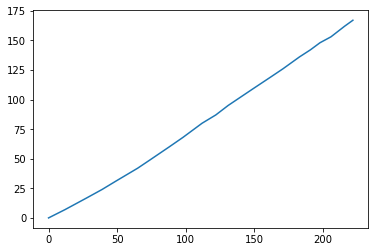

In [4]:
i = 4
plt.plot(cursor_trajectory[i][:, 0], cursor_trajectory[i][:, 1])


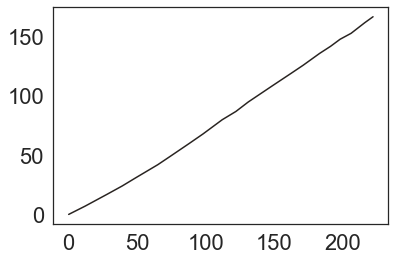

In [281]:
for i in range(i):
    plt.plot(cursor_trajectory[i][:, 0], cursor_trajectory[i][:, 1])
    # plt.plot(cursor_trajectory[i])

In [5]:
df = pd.DataFrame({'p_id' : np.repeat(np.arange(num_participants), num_blocks*num_trials),
                    'Trial': np.tile(np.arange(768), 60),
                    'Block': np.tile(np.repeat(np.arange(12), 64), 60), 
                    'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Sudden', 'Gradual', 'Gradual']), 768), 15),
                    'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 768), 30),
                   'cursor trajectory': np.array(cursor_trajectory, dtype = object)
})

In [160]:
df.to_csv('all_trajectories.csv')

In [6]:
def find_angles(a, b, c):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c

  # cosine_angle = np.dot(ab, ac) / (np.linalg.norm(ab) * np.linalg.norm(ac))
  # angle = np.arccos(cosine_angle)
  # signed_angle = np.arctan2(ba[1],ba[0]) - np.arctan2(bc[1],bc[0])

  angles = []
  for v1, v2 in zip(ab, ac):
    dotprod = np.dot(np.abs(v1), np.abs(v2))
    ab_magnitudes = np.linalg.norm(np.abs(v1))
    ac_magnitudes = np.linalg.norm(np.abs(v2))
  # # print(dot_products.shape)
  # # Calculate the angles between ab and ac.
    angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))

  return np.nanmean(angles)

In [7]:
def comp_avg_ang_error(traj):
    # try:
    # print(traj)
    traj = traj.astype(float)/np.nanmax(traj)
    
    end_point = traj[-1]
    curr_point = np.array(traj[:-1])
    next_point = np.array(traj[1:])
    
    angles = find_angles(curr_point, end_point, next_point)
    return angles
    # except:
    #     return np.NaN

In [62]:
traj[:, 1]/np.abs(traj[-1, 1])

array([ 0.        , -0.00609756, -0.00609756, -0.01219512, -0.01219512,
       -0.01829268, -0.01829268, -0.01829268, -0.02439024, -0.02439024,
       -0.0304878 , -0.0304878 , -0.0304878 , -0.0304878 , -0.0304878 ,
       -0.03658537, -0.03658537, -0.04268293, -0.04268293, -0.04878049,
       -0.04878049, -0.04878049, -0.04878049, -0.05487805, -0.05487805,
       -0.06097561, -0.06097561, -0.06707317, -0.07317073, -0.07926829,
       -0.08536585, -0.09146341, -0.09756098, -0.10365854, -0.11585366,
       -0.12804878, -0.13414634, -0.15243902, -0.16463415, -0.17073171,
       -0.18292683, -0.19512195, -0.21341463, -0.23170732, -0.23780488,
       -0.25609756, -0.27439024, -0.29268293, -0.30487805, -0.32926829,
       -0.35365854, -0.37804878, -0.39634146, -0.42682927, -0.45731707,
       -0.48170732, -0.5       , -0.5304878 , -0.55487805, -0.58536585,
       -0.60365854, -0.63414634, -0.66463415, -0.69512195, -0.7195122 ,
       -0.75      , -0.7804878 , -0.81097561, -0.83536585, -0.84

In [63]:
def comp_init_ang_error(traj, proportion=0.1):
    a, b = traj[:, 0]/np.abs(traj[-1, 0]), traj[:, 1]/np.abs(traj[-1, 1])
    cutoff_dist = proportion

    try:
        for cutoff_point in zip(a, b):
            euclid_dist = np.sqrt(cutoff_point[0]**2 + cutoff_point[1]**2)
            if euclid_dist > cutoff_dist:
                break
    except:
        return np.NaN
    try:
        end_point = traj[-1]
        v1 = end_point - np.array([0, 0])
        v2 = np.array(cutoff_point) - np.array([0, 0])

        dotprod = np.dot(v1, v2)
        v1_magnitudes = np.linalg.norm(v1)
        v2_magnitudes = np.linalg.norm(v2)
        return np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
    except:
        return np.NaN

In [47]:
def angular_dist(b, a, c):
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    signed_angle = np.arctan2(ba[1],ba[0]) - np.arctan2(bc[1],bc[0])


    return angle#, signed_angle

def calc_angular_error(traj):    
    init_error = np.zeros(64)
    mean_error = np.zeros(64)
    for j in range(64):
        traj_ang_errors = list()
        trajx, trajy = traj['x'][0][j][0].astype(float), traj['y'][0][j][0].astype(float)
        # print(trajx)
        #end_pointx, end_pointy  = square_coord['squareX'][0][j], square_coord['squareY'][0][j]
        end_pointx, end_pointy  = traj['x'][0][j][0][-1], traj['y'][0][j][0][-1]


        for i in range(len(trajx) - 1):
            ang_dist = angular_dist(np.array([trajx[i], trajy[i]]), np.array([trajx[i+1], trajy[i+1]]), np.array([trajx[-1], trajy[-1]]))
            traj_ang_errors.append(ang_dist)
        
        # init_error[j] = np.nanmean(traj_ang_errors[:np.argmax(velocity[j])])
        mean_error[j] = np.nanmean(traj_ang_errors)
    return mean_error

In [64]:
# df_relearn = pd.read_csv('all_trajectories.csv')
df['cursor trajectory'] = cursor_trajectory
errors = []
for traj in cursor_trajectory:
    # print(traj)
    errors.append(comp_init_ang_error(traj))


C:\Users\tejas\AppData\Local\Temp\ipykernel_2304\2617656609.py:20: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))


In [71]:
df['init errors'] = np.ravel(errors)
df.loc[df['Block'] == 11, 'init errors'] = -df.loc[df['Block'] == 11, 'init errors']
# df.loc[df['p_id']%2 == 1, 'Emphasis'] = 'Accuracy'
# df.loc[df['p_id']%2 == 0, 'Emphasis'] = 'Speed'

# df.loc[df['p_id']%4 == 0, 'Rotation'] = 'Sudden'
# df.loc[df['p_id']%4 == 1, 'Rotation'] = 'Sudden'
# df.loc[df['p_id']%4 == 2, 'Rotation'] = 'Gradual'
# df.loc[df['p_id']%4 == 3, 'Rotation'] = 'Gradual'
df['init errors degrees'] = df['init errors']*180/np.pi



In [311]:
smoothed = []
for participant in df.p_id.unique():
    for block in range(12):
        temp = df.loc[((df['p_id'] == participant) & (df['Block'] == block)), 'avg errors'].values
        df.loc[((df['p_id'] == participant) & (df['Block'] == block)), 'avg errors'] = np.nan_to_num(temp, nan = np.nanmedian(temp))
        smoothed.append(gaussian_filter(df.loc[((df['p_id'] == participant) & (df['Block'] == block)), 'avg errors'].values, sigma=2))

smoothed = np.ravel(smoothed)

df['smoothed avg error'] = smoothed
df['smoothed avg error degrees'] = df['smoothed avg error']*180/np.pi
# df = df.drop('cursor trajectory', axis = 1)

In [313]:
def clean_data(df):
    # Replace gaps forward from the previous valid value in: 'avg errors', 'avg errors degrees' and 2 other columns
    df = df.fillna({'avg errors': df['smoothed avg error'].ffill(), 'avg errors degrees': df['avg errors degrees'].ffill(), 'smoothed avg error': df['smoothed avg error'].ffill(), 'smoothed avg error degrees': df['smoothed avg error degrees'].ffill()})
    return df

df_clean = clean_data(df.copy())
df_clean.head()

,p_id,Trial,Block,Rotation,Emphasis,avg errors,avg errors degrees,smoothed avg error,smoothed avg error degrees
0,0,0,0,Sudden,Speed,0.087757,0.087757,0.114167,6.541259
1,0,1,0,Sudden,Speed,0.109257,0.109257,0.111866,6.409433
2,0,2,0,Sudden,Speed,0.229315,0.229315,0.104513,5.988174
3,0,3,0,Sudden,Speed,0.044903,0.229315,0.091834,5.261720
4,0,4,0,Sudden,Speed,0.041478,0.041478,0.078135,4.476785


In [328]:
df = df.drop('cursor trajectory', axis = 1)

In [330]:
df.to_csv('df_allphases.csv')

In [67]:
df

,p_id,Trial,Block,Rotation,Emphasis,cursor trajectory,init errors
0,0,0,0,Sudden,Speed,"[[0, 0], [30, -31], [43, -43], [53, -52], [62,...",0.140367
1,0,1,0,Sudden,Speed,"[[0, 0], [-12, 14], [-26, 30], [-38, 43], [-56...",0.037216
2,0,2,0,Sudden,Speed,"[[0, 0], [31, -25], [63, -50], [84, -65], [105...",0.048070
3,0,3,0,Sudden,Speed,"[[0, 0], [-22, -16], [-35, -26], [-47, -34], [...",0.059439
4,0,4,0,Sudden,Speed,"[[0, 0], [12, 7], [28, 17], [39, 24], [49, 31]...",0.034114
...,...,...,...,...,...,...,...
46075,59,763,11,Gradual,Accuracy,"[[0, 0], [11, 32], [11, 32], [12, 34], [12, 35...",0.363901
46076,59,764,11,Gradual,Accuracy,"[[0, 0], [11, -3], [12, -3], [14, -4], [16, -4...",0.412636
46077,59,765,11,Gradual,Accuracy,"[[0, 0], [0, 0], [0, -1], [0, -2], [0, -3], [0...",0.800991
46078,59,766,11,Gradual,Accuracy,"[[0, 0], [-1, -3], [-2, -4], [-2, -6], [-3, -7...",0.491390


In [334]:
df_learn = df.loc[df['Block'] < 11].reset_index().drop('index', axis = 1)
df_washout = df.loc[df['Block'] == 11].reset_index().drop('index', axis = 1)
df_washout['Trial'] = np.tile(np.arange(64), 60)
df_learn.to_csv('df_learn.csv')
df_washout.to_csv('df_washout.csv')

In [ ]:
# df['avg errors smooth'] = 
gaussian_filter(avg[participant][block], sigma = 2)


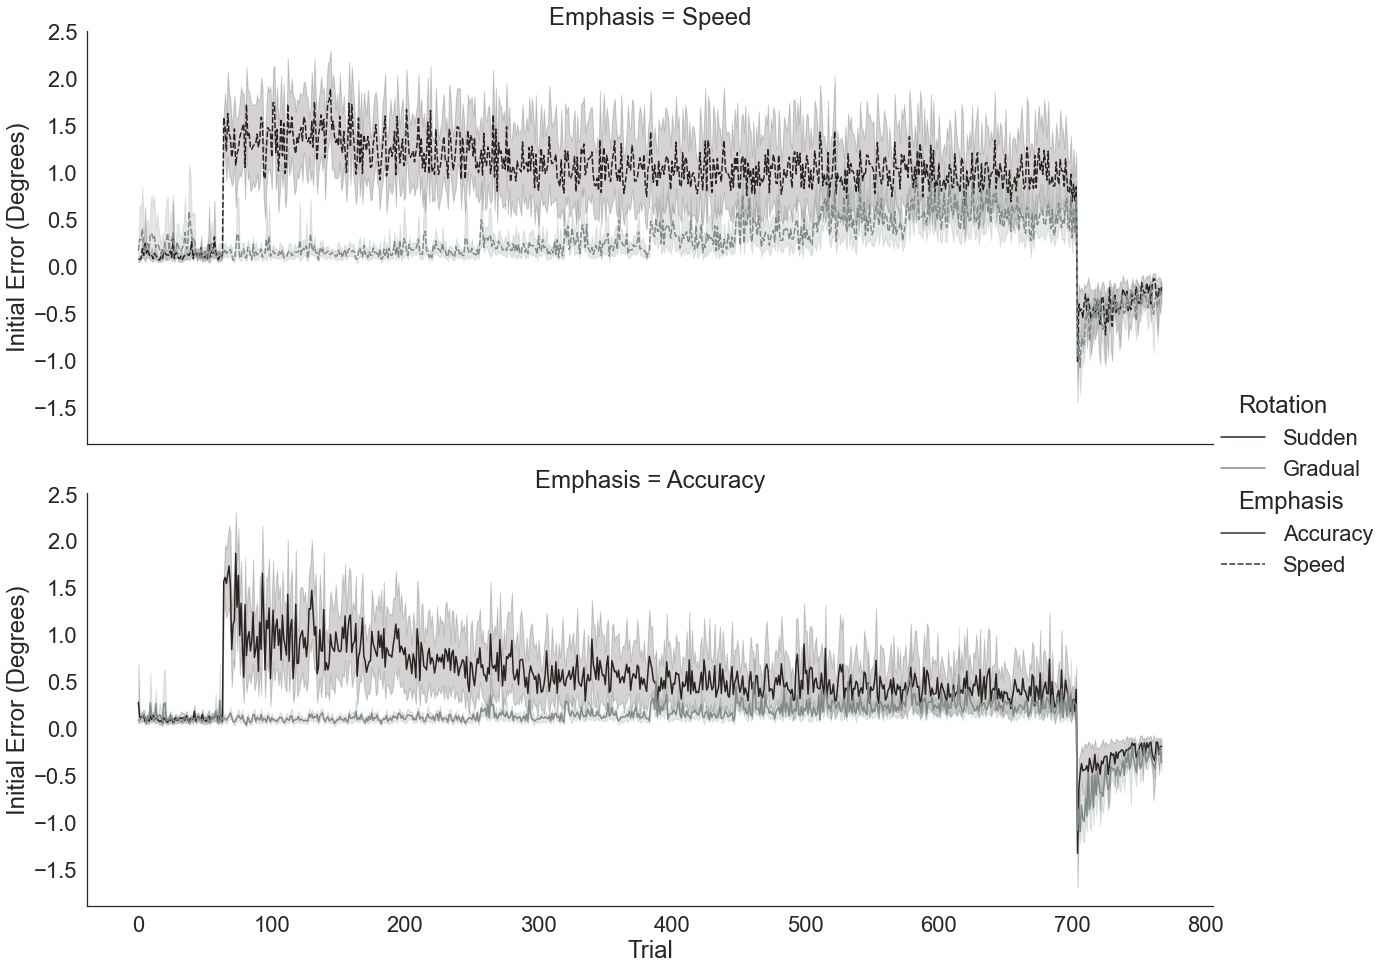

In [72]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'init errors', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Initial Error (Degrees)')

# draw lines:
# for ax in g.axes.ravel():
#     ax.vlines(x = 64, ymax=100, ymin = -100, color = 'black', linestyles = '--')
#     ax.vlines(x = 64*8, ymax=100, ymin = -100, color = 'black', linestyles = '--')
#     ax.vlines(x = 64*9, ymax=100, ymin = -100, color = 'black', linestyles = '--')

#     ax.hlines(y=0, xmin = 0, xmax = 640, color = 'black', linestyles = '--')

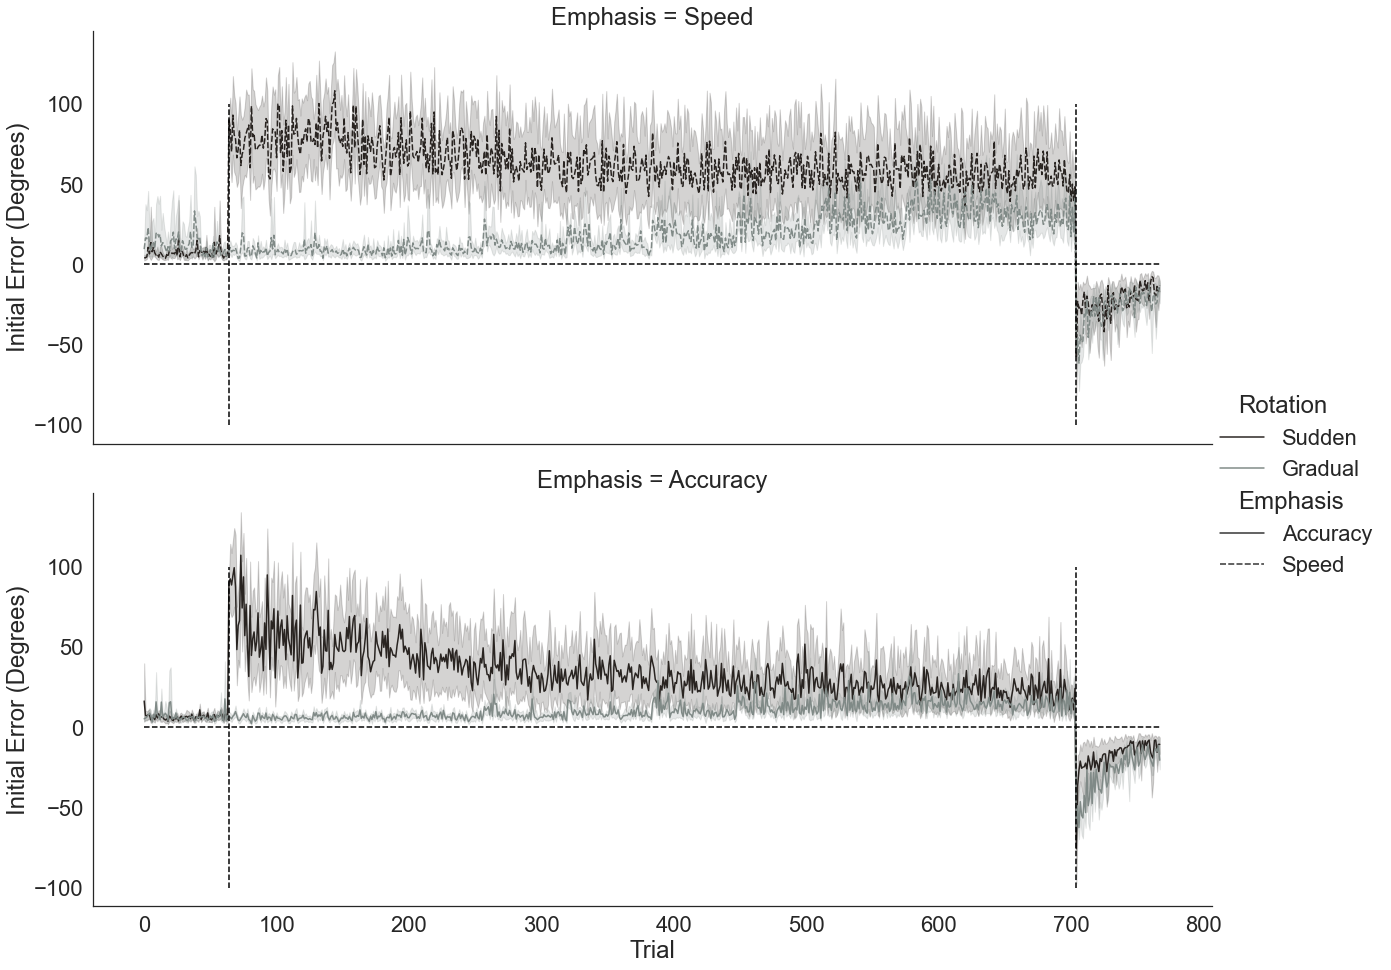

In [88]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'init errors degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Initial Error (Degrees)')

# draw lines:
for ax in g.axes.ravel():
    ax.vlines(x = 64, ymax=100, ymin = -100, color = 'black', linestyles = '--')
    ax.vlines(x = 64*11, ymax=100, ymin = -100, color = 'black', linestyles = '--')

    ax.hlines(y=0, xmin = 0, xmax = 768, color = 'black', linestyles = '--')

In [79]:
df = df.drop('cursor trajectory', axis = 1)
df.to_csv('df_allphases.csv')


In [86]:
df_learn = df.loc[((df['Block'] > 0) & (df['Block'] < 11))].reset_index().drop('index', axis = 1)
df_learn.to_csv('df_learn.csv')

In [91]:
df_blockwise = pd.read_csv('df_blockwise.csv')

In [ ]:
df_allphases = pd.read_csv('df_allphases.csv')

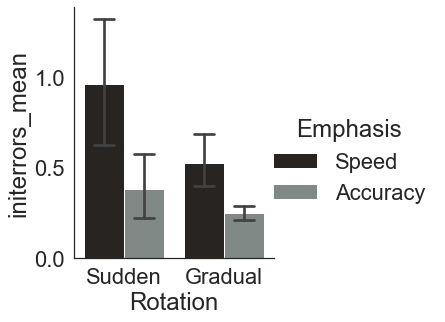

In [95]:
sns.catplot(y = 'initerrors_mean', x = 'Rotation', hue = 'Emphasis', 
            data = df_blockwise.loc[((df_blockwise['Block'] == 10))], 
            kind = 'bar', capsize = 0.2)

In [ ]:
df_allphases_blockwise['difference'] = df_allphases_blockwise['initerrors_mean'].diff(periods= 2)

In [ ]:
g = sns.catplot(y = 'difference', x = 'Rotation', hue = 'Emphasis', 
            data = df_allphases_blockwise.loc[((df_allphases_blockwise['block no'] == 8))], 
            kind = 'bar', capsize = 0.2)
g.set_ylabels('Error Difference \n Relearning - Learning')


In [3]:
num_participants = 60
num_blocks = 12
num_trials = 64
participants = np.arange(1000, 1000 + num_participants)
blocks = np.arange(0, num_blocks)
cursor_trajectory = []
for participant in participants:
    for block in blocks:
        temp =  scipy.io.loadmat(f'Data/data{participant}/actual_trajectories/trajectories{block}.mat')
        for trial in np.arange(num_trials):
            cursor_trajectory.append(np.array((temp['x'].T[trial][0], temp['y'].T[trial][0])).T.reshape(temp['x'].T[trial][0].shape[1], 2))


def comp_init_ang_error(traj, proportion=0.1):
    a, b = traj[:, 0]/np.abs(traj[-1, 0]), traj[:, 1]/np.abs(traj[-1, 1])
    cutoff_dist = proportion

    try:
        for cutoff_point in zip(a, b):
            euclid_dist = np.sqrt(cutoff_point[0]**2 + cutoff_point[1]**2)
            if euclid_dist > cutoff_dist:
                break
    except:
        return np.NaN
    try:
        end_point = traj[-1]
        v1 = end_point - np.array([0, 0])
        v2 = np.array(cutoff_point) - np.array([0, 0])

        dotprod = np.dot(v1, v2)
        v1_magnitudes = np.linalg.norm(v1)
        v2_magnitudes = np.linalg.norm(v2)
        cross = np.cross(v1, v2)
        if cross > 0:
            sign = -1
        else:
            sign = 1
        return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
    except:
        return np.NaN

In [4]:
init_signed_error = []
for traj in cursor_trajectory:
    init_signed_error.append(comp_init_ang_error(traj))

C:\Users\tejas\AppData\Local\Temp\ipykernel_13764\1865050589.py:38: RuntimeWarning: invalid value encountered in arccos
  return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))


In [9]:
df = pd.DataFrame({'p_id' : np.repeat(np.arange(num_participants), num_blocks*num_trials),
                    'Trial': np.tile(np.arange(768), 60),
                    'Block': np.tile(np.repeat(np.arange(12), 64), 60), 
                    'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Sudden', 'Gradual', 'Gradual']), 768), 15),
                    'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 768), 30),
                    'init signed error': np.array(init_signed_error),
                    'init signed error degrees': np.array(init_signed_error)*180/np.pi,

                   
})

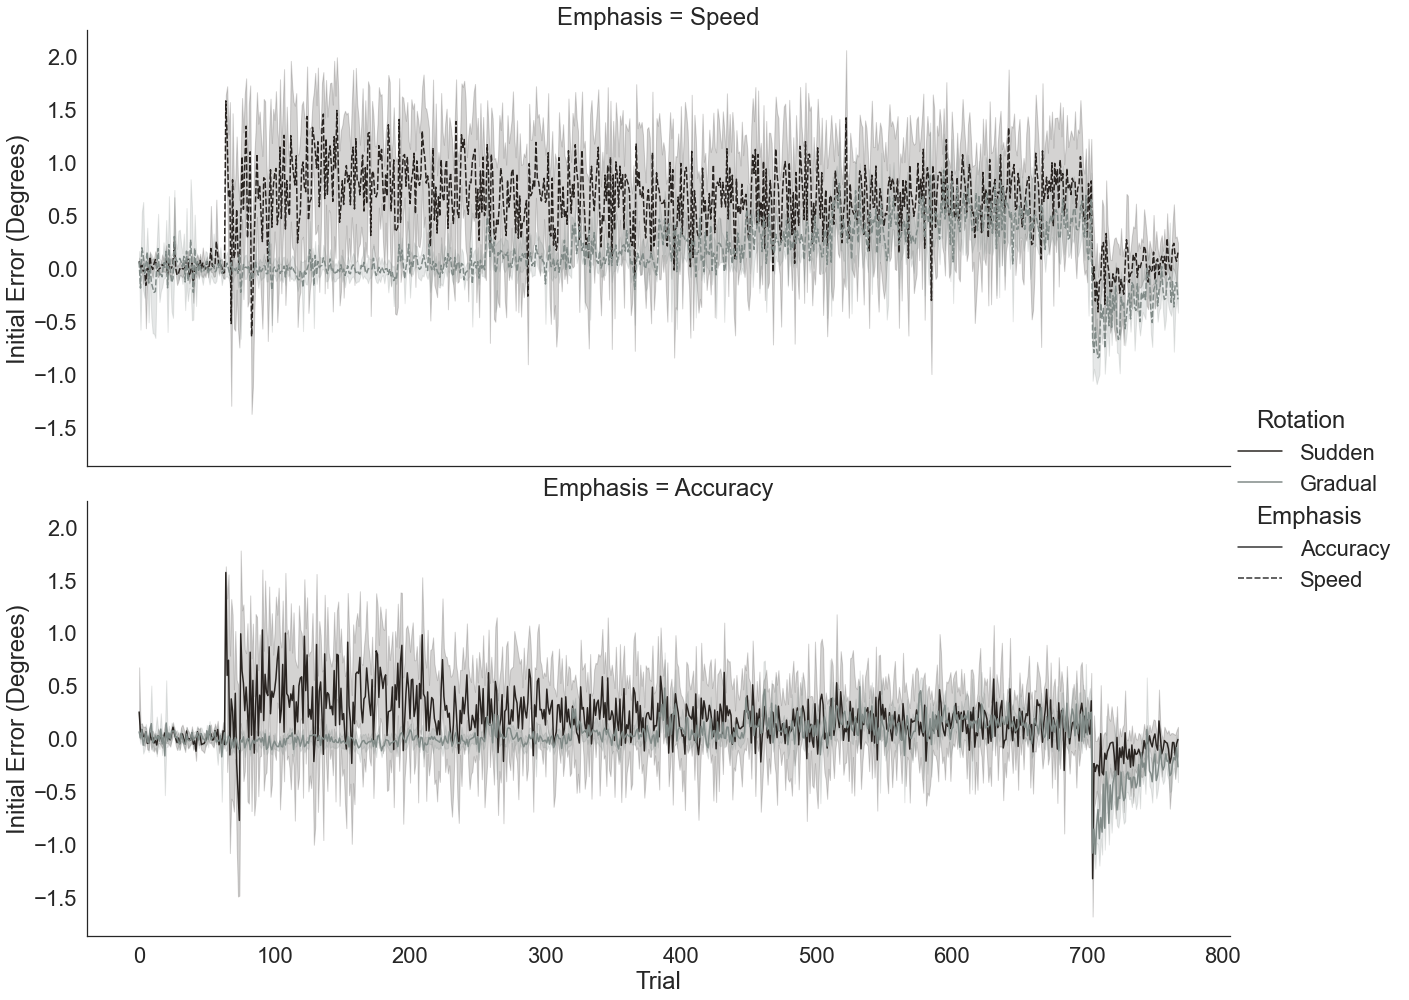

In [7]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'init signed error degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Initial Error (Degrees)')


In [12]:
def blockwise_data(df):
    # Performed 2 aggregations grouped on columns: 'p_id', 'Block' and 2 other columns
    df = df.groupby(['p_id', 'Block', 'Rotation', 'Emphasis']).agg(initsignederror_mean=('init signed error', 'mean'), initsignederrordegrees_mean=('init signed error degrees', 'mean')).reset_index()
    return df

df_blockwise = blockwise_data(df.copy())


In [14]:
df_blockwise

,p_id,Block,Rotation,Emphasis,initsignederror_mean,initsignederrordegrees_mean
0,0,0,Sudden,Speed,0.016827,0.964139
1,0,1,Sudden,Speed,-0.189981,-10.885111
2,0,2,Sudden,Speed,-0.311104,-17.824969
3,0,3,Sudden,Speed,-0.439226,-25.165817
4,0,4,Sudden,Speed,-0.349295,-20.013121
...,...,...,...,...,...,...
715,59,7,Gradual,Accuracy,0.239879,13.744048
716,59,8,Gradual,Accuracy,0.242714,13.906476
717,59,9,Gradual,Accuracy,0.264105,15.132107
718,59,10,Gradual,Accuracy,0.272232,15.597721


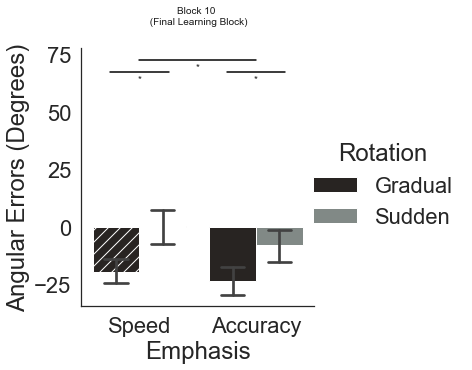

In [17]:
# df_blockwise['initerrors_mean_degrees'] = df_blockwise['initerrors_mean']*180/np.pi
g = sns.catplot(x = 'Emphasis', hue = 'Rotation', y = 'initsignederrordegrees_mean', col = 'Block',
            data = df_blockwise.loc[((df_blockwise['Block']==11))],
            kind = 'bar', capsize = 0.2, hue_order=['Gradual', 'Sudden'] 
            )
x1, x2 = 0, 1
y, h, col = df_blockwise.loc[(df_blockwise['Block'] == 10)]['initsignederrordegrees_mean'].max()-35, 0.02, 'k'
plt.text(0.5, y+h+25, "Block 10 \n (Final Learning Block)", ha='center', va='bottom', color=col)
plt.text(0.5, y+h+5, "*", ha='center', va='bottom', color=col)
plt.axhline(y=y+h+10, xmin=0.25, xmax=0.75, color = 'black')
plt.text(0, y+h, "*", ha='center', va='bottom', color=col)
plt.axhline(y=y+h+5, xmin=0.125, xmax=0.375, color = 'black')
plt.text(1, y+h, "*", ha='center', va='bottom', color=col)
plt.axhline(y=y+h+5, xmin=0.625, xmax=0.875, color = 'black')

g.set(ylabel='Angular Errors (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])


In [21]:
df_learn = df.loc[((df['Block'] > 0) & (df['Block'] < 11))].reset_index().drop('index', axis = 1)
df_learn.to_csv('df_learn_signed.csv') 
#Used data wrangler to fill missing values and resaved it.

In [24]:
df_learn

,p_id,Trial,Block,Rotation,Emphasis,init signed error,init signed error degrees
0,0,64,1,Sudden,Speed,1.753594,100.473528
1,0,65,1,Sudden,Speed,2.041179,116.950952
2,0,66,1,Sudden,Speed,0.902901,51.732439
3,0,67,1,Sudden,Speed,2.159052,123.704559
4,0,68,1,Sudden,Speed,0.220566,12.637477
...,...,...,...,...,...,...,...
38395,59,699,10,Gradual,Accuracy,0.002393,0.137127
38396,59,700,10,Gradual,Accuracy,0.245410,14.060975
38397,59,701,10,Gradual,Accuracy,0.069254,3.967951
38398,59,702,10,Gradual,Accuracy,-0.001036,-0.059338
